# P3 - Movie Genre Classification

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

### Objective

Classify a movie genre based on its plot.
Source: https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

- Input: movie plot
- Output: Probability of the movie belong to each genre

### Evaluation

- 50% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

### Deatline

- The project must be carried out in the groups assigned.
- Use clear and rigorous procedures.
- The delivery of the project is on August 1st, 2021, 11:59 pm, through Bloque Neón.
- No projects will be received after the delivery time or by any other means than the one established.

### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.
See https://arxiv.org/abs/1702.01992

## Sample Submission

In [1]:
# Librerías

import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

import keras
from keras import backend as K

import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#pip install livelossplot
from livelossplot import PlotLossesKeras
%matplotlib inline

import nltk
from nltk.corpus import stopwords

from xgboost import XGBClassifier


In [2]:
df_train = pd.read_csv('DataSet/dataTraining.csv', encoding='UTF-8', index_col=0)
df_test = pd.read_csv('Dataset/dataTesting.csv', encoding='UTF-8', index_col=0)

In [3]:
df_train.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
df_train['rating'] = df_train['rating'].astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    7895 non-null   int64 
 1   title   7895 non-null   object
 2   plot    7895 non-null   object
 3   genres  7895 non-null   object
 4   rating  7895 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 370.1+ KB


In [5]:
df_test.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3383 entries, 1 to 11275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    3383 non-null   int64 
 1   title   3383 non-null   object
 2   plot    3383 non-null   object
dtypes: int64(1), object(2)
memory usage: 105.7+ KB


### Create y

In [7]:
df_train['genres'] = df_train['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y = le.fit_transform(df_train['genres'])
y.shape

(7895, 24)

In [8]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

### Vocabulary

In [9]:
## eliminar caracteres especiales
X= pd.DataFrame(df_train['plot'])
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "0","1","2","3","4","5","6","7","8","9",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–",'$','®','¡',
             '£','°','¹','½','à','á','â','ä','å','ç',
              'è','é','ê','ë','í','ï','ñ','ò','ó','ô',
              'ö','ø','ù','ú','û','ü','ʼ']
for char in spec_chars:
    X = X.apply(lambda x: x.str.replace(char, ''))
    
# Crear el vocabulario
X= X['plot']

# Limpiar el vocabulario
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

X= X.apply(clean_text)
X = X.tolist()
X

['story single father takes eight year old son work railroad drawbridge bridge tender day boy meets woman boarding train drug abuser bridge father goes engine room tells son stay edge nearby lake ship comes bridge lifted though supposed arrive hour later train happens arrive son sees tries warn father able see oncoming train approaches son falls drawbridge gear works attempting lower bridge leaving father horrific choice father lowers bridge gears crushing boy people train completely oblivious fact boy died trying save drug addict woman happened look train window movie ends man wandering new city meets woman longer drug addict holding small baby relevant narratives run parallel namely one female drug addict meet climax tumultuous film',
 'serial killer decides teach secrets satisfying career video store clerk',
 'sweden female blackmailer disfiguring facial scar meets gentleman lives beyond means become accomplices blackmail falls love bitterly resigned impossibility returning affectio

In [10]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [11]:
print(vocabulary)

{'r': 1, 'n': 2, 'w': 3, 'o': 4, 'g': 5, 'i': 6, 'j': 7, 'v': 8, ' ': 9, 'd': 10, 'm': 11, 't': 12, 'p': 13, 'x': 14, 'f': 15, 'z': 16, 'q': 17, 'b': 18, 'k': 19, 'h': 20, 'a': 21, 'c': 22, 'l': 23, 'u': 24, 's': 25, 'y': 26, 'e': 27}


In [12]:
# some statistics to define Max len
YY = []
for i in range(1,len(X)):
    YY.append(len(X[i]))

import statistics
print('Mean',statistics.mean(YY))
print('Min',min(YY))
print('Max',max(YY))
print('Median',np.percentile(YY, 50))
print('75%',np.percentile(YY, 75))
print('95%',np.percentile(YY, 95))

Mean 478.4980998226501
Min 0
Max 5544
Median 416.0
75% 607.0
95% 1079.3499999999995


In [13]:
# Max len
max_plot_len = 250  #Set the max number of words in each complaint
X_ = [x[:max_plot_len] for x in X]
# Convert characters to int and pad
X_ = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X_]

In [14]:
# check example
print(X[0])
print(X_[0])

story single father takes eight year old son work railroad drawbridge bridge tender day boy meets woman boarding train drug abuser bridge father goes engine room tells son stay edge nearby lake ship comes bridge lifted though supposed arrive hour later train happens arrive son sees tries warn father able see oncoming train approaches son falls drawbridge gear works attempting lower bridge leaving father horrific choice father lowers bridge gears crushing boy people train completely oblivious fact boy died trying save drug addict woman happened look train window movie ends man wandering new city meets woman longer drug addict holding small baby relevant narratives run parallel namely one female drug addict meet climax tumultuous film
[25, 12, 4, 1, 26, 9, 25, 6, 2, 5, 23, 27, 9, 15, 21, 12, 20, 27, 1, 9, 12, 21, 19, 27, 25, 9, 27, 6, 5, 20, 12, 9, 26, 27, 21, 1, 9, 4, 23, 10, 9, 25, 4, 2, 9, 3, 4, 1, 19, 9, 1, 21, 6, 23, 1, 4, 21, 10, 9, 10, 1, 21, 3, 18, 1, 6, 10, 5, 27, 9, 18, 1, 6, 1

In [15]:
# create pad
X_pad = sequence.pad_sequences(X_, maxlen=max_plot_len)
X_pad

array([[25, 12,  4, ..., 23, 21, 12],
       [ 0,  0,  0, ..., 27,  1, 19],
       [25,  3, 27, ...,  9, 18, 27],
       ...,
       [ 0,  0,  0, ..., 21,  2, 10],
       [11,  1, 25, ..., 25,  9,  5],
       [ 0,  0,  0, ...,  1, 27, 27]], dtype=int32)

### Train / Test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=1234)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6316, 250) (6316, 24)
(1579, 250) (1579, 24)


In [17]:
X_train

array([[10, 21,  2, ..., 24, 15, 15],
       [ 0,  0,  0, ...,  6, 10, 27],
       [ 3, 21,  2, ...,  6, 21,  2],
       ...,
       [ 2,  4,  1, ..., 10, 26,  9],
       [18,  1,  6, ..., 27, 25,  9],
       [ 0,  0,  0, ..., 24, 27, 25]], dtype=int32)

In [18]:
X_test

array([[ 0,  0,  0, ...,  5, 27,  1],
       [25, 12, 21, ...,  4, 21, 22],
       [ 8, 21, 23, ...,  9, 21, 22],
       ...,
       [13, 21, 24, ...,  9, 22,  1],
       [11, 21,  2, ..., 27,  2, 12],
       [11, 21, 26, ..., 27, 10,  6]], dtype=int32)

In [19]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Model

In [24]:
from keras.layers import Activation, Dense, Flatten, SpatialDropout1D

In [33]:
#The first layer is the embedded layer that uses 100 length vectors to represent each word.
#SpatialDropout1D performs variational dropout in NLP models.
#The next layer is the LSTM layer with 100 memory units.
#The output layer must create 24 output values, one for each class.
#Activation function is softmax for multi-class classification.
#Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

model = Sequential()
#model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_plot_len)) #MAX_NB_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH
model.add(Embedding(len(vocabulary) + 1, 100, input_length=max_plot_len)) #MAX_NB_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH
model.add(SpatialDropout1D(0.2))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(32)) 
#model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.add(Dense(24, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          2800      
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                7488      
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                408       
Total params: 10,696
Trainable params: 10,696
Non-trainable params: 0
_________________________________________________________________


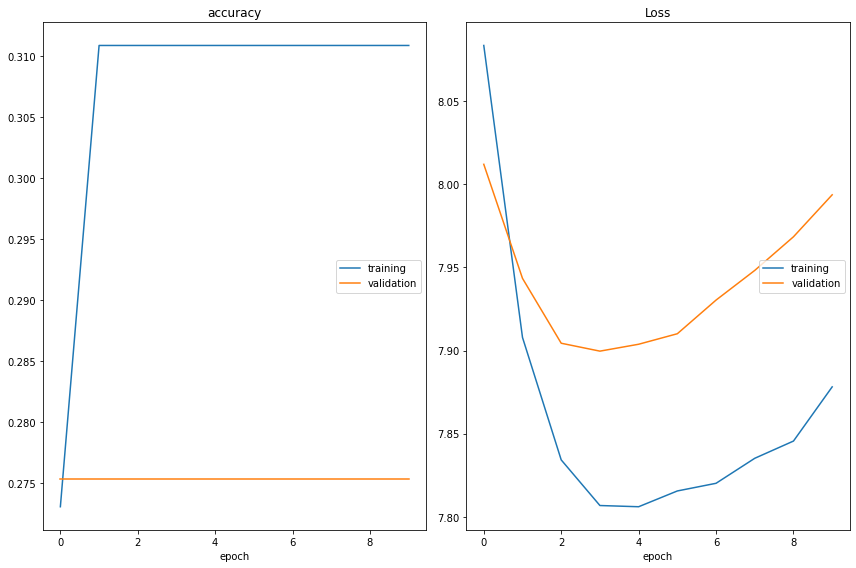

accuracy
	training         	 (min:    0.273, max:    0.311, cur:    0.311)
	validation       	 (min:    0.275, max:    0.275, cur:    0.275)
Loss
	training         	 (min:    7.806, max:    8.084, cur:    7.878)
	validation       	 (min:    7.900, max:    8.012, cur:    7.994)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

#model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=128, epochs=10, verbose=1,
#          callbacks=[PlotLossesKeras()])

model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

#model.fit(X_train, y_train, validation_split=0.1, batch_size=128, epochs=10, verbose=1,
#          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [35]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

50/50 [==============================] - 2s 39ms/step - loss: 8.3541 - accuracy: 0.2875
Test set
  Loss: 8.354
  Accuracy: 0.288


### Precit over test dataframe

In [36]:
## eliminar caracteres especiales
X1= pd.DataFrame(df_test['plot'])
for char in spec_chars:
    X1 = X1.apply(lambda x: x.str.replace(char, ''))
    
# Crear el vocabulario
X1= X1['plot']

# Limpiar el vocabulario
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

X1 = X1.apply(clean_text)
X1 = X1.tolist()
X1

['meets fate shall sealed fate theresa osborne running along beach stumbles upon bottle washed shore inside message reading letter feels moved yet felt violated someone thoughts love man never met theresa tracks author letter small town wilmington two lovers crossed paths yet one let go past',
 'true story billy hayes american college student caught smuggling drugs turkey thrown prison',
 'martin vail left chicago da office become successful criminal lawyer success predicated working high profile cases fights get case naive nineteen year old rural kentuckian aaron stampler altar boy accused vicious bludgeoning death archbishop rushman chicago story aaron tells marty abused father room murder committed third party shadowy figure see blacked commonly happens remembering anything blackout period awoke covered archbishop blood fright reason ran police also states reason kill archbishop loved father wished marty care guilty innocent needs know truth defend adequately unlike rest world marty

In [37]:
# Max len
#max_plot_len = 500  #Set the max number of words in each complaint
X1_ = [x[:max_plot_len] for x in X1]
# Convert characters to int and pad
X1_ = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X1_]

In [38]:
print(X1[0])
print(X1_[0])

meets fate shall sealed fate theresa osborne running along beach stumbles upon bottle washed shore inside message reading letter feels moved yet felt violated someone thoughts love man never met theresa tracks author letter small town wilmington two lovers crossed paths yet one let go past
[11, 27, 27, 12, 25, 9, 15, 21, 12, 27, 9, 25, 20, 21, 23, 23, 9, 25, 27, 21, 23, 27, 10, 9, 15, 21, 12, 27, 9, 12, 20, 27, 1, 27, 25, 21, 9, 4, 25, 18, 4, 1, 2, 27, 9, 1, 24, 2, 2, 6, 2, 5, 9, 21, 23, 4, 2, 5, 9, 18, 27, 21, 22, 20, 9, 25, 12, 24, 11, 18, 23, 27, 25, 9, 24, 13, 4, 2, 9, 18, 4, 12, 12, 23, 27, 9, 3, 21, 25, 20, 27, 10, 9, 25, 20, 4, 1, 27, 9, 6, 2, 25, 6, 10, 27, 9, 11, 27, 25, 25, 21, 5, 27, 9, 1, 27, 21, 10, 6, 2, 5, 9, 23, 27, 12, 12, 27, 1, 9, 15, 27, 27, 23, 25, 9, 11, 4, 8, 27, 10, 9, 26, 27, 12, 9, 15, 27, 23, 12, 9, 8, 6, 4, 23, 21, 12, 27, 10, 9, 25, 4, 11, 27, 4, 2, 27, 9, 12, 20, 4, 24, 5, 20, 12, 25, 9, 23, 4, 8, 27, 9, 11, 21, 2, 9, 2, 27, 8, 27, 1, 9, 11, 27, 12, 9, 12,

In [41]:
X1_pad = sequence.pad_sequences(X1_, maxlen=max_plot_len)
X1_pad

array([[11, 27, 27, ...,  3,  4,  9],
       [ 0,  0,  0, ..., 25,  4,  2],
       [11, 21,  1, ..., 21,  2,  9],
       ...,
       [ 7,  4, 27, ...,  1,  1,  4],
       [25,  6,  2, ..., 21, 11, 27],
       [ 0,  0,  0, ..., 23, 27,  1]], dtype=int32)

In [40]:
# Predict over df_test

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred=model.predict(X1_pad)
y_pred=pd.DataFrame(y_pred, index=df_test.index, columns=cols)
y_pred.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.080765,0.010946,0.001623,0.005811,0.246551,0.036424,0.011946,0.208216,0.026205,0.032459,...,0.00366,0.041057,2.136914e-08,0.11395,0.039007,0.000023,0.001407,0.105103,0.004129,0.002655
4,0.080765,0.010946,0.001623,0.005811,0.246551,0.036424,0.011946,0.208216,0.026205,0.032459,...,0.00366,0.041057,2.136914e-08,0.11395,0.039007,0.000023,0.001407,0.105103,0.004129,0.002655
5,0.080765,0.010946,0.001623,0.005811,0.246551,0.036424,0.011946,0.208216,0.026205,0.032459,...,0.00366,0.041057,2.136914e-08,0.11395,0.039007,0.000023,0.001407,0.105103,0.004129,0.002655
6,0.080765,0.010946,0.001623,0.005811,0.246551,0.036424,0.011946,0.208216,0.026205,0.032459,...,0.00366,0.041057,2.136914e-08,0.11395,0.039007,0.000023,0.001407,0.105103,0.004129,0.002655
7,0.080765,0.010946,0.001623,0.005811,0.246551,0.036424,0.011946,0.208216,0.026205,0.032459,...,0.00366,0.041057,2.136914e-08,0.11395,0.039007,0.000023,0.001407,0.105103,0.004129,0.002655


In [ ]:
# Export
#y_pred.to_csv('pred_genres_text_NN.csv', index_label='ID')